# Exam Machine Learning with Python

Submitted by : 

Dries Luts (dries-luts@hotmail.com)<br />
Bino Maiheu (binomaiheu@gmail.com)<br />
Marijke Van De Steene (marijkevandesteene@hotmail.com)<br />

This notebook is submitted by the group above for the course exame "Machine Learning with Python", taught by Bart Van Rompaye. Course IPVW-
ICES 2024, **due date**: 2024-07-03 23:59. 

# Changelog

- **2024-06-05** [MV] : Initial version
- **2024-06-06** [BM] : Consolidated structure, imported initial analysis from notebooks 



# Initialisation

## Packages

In [294]:
# -- Importing packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as stats
import scikitplot as skplt 
import pickle

from pathlib import Path

In [295]:
# -- Import Machine learning libraries
from sklearn.preprocessing import StandardScaler  # for preprocessing & scaling
from sklearn.preprocessing import PolynomialFeatures  # for polynomial features preprocessing
from sklearn.impute import SimpleImputer, KNNImputer   # for missing values imputation
from sklearn.model_selection import train_test_split  # train-test splits
from sklearn.model_selection import StratifiedKFold  # K-fold resampling, stratified
from sklearn.model_selection import GridSearchCV  # Hyperparameter tuning
from sklearn.calibration import CalibratedClassifierCV  # Hyperparameter tuning with calibration
from sklearn.calibration import calibration_curve  # calibration curve plotting
from sklearn.calibration import CalibrationDisplay  # calibration curve plotting
from sklearn.metrics import confusion_matrix  # performance metrics, confusion matrix
from sklearn.metrics import classification_report  # performance matrix classifiaction report
from sklearn.metrics import roc_auc_score  # Area Under Receiver Operating Characteristics
from sklearn.metrics import roc_curve  # ROC
from sklearn.metrics import RocCurveDisplay  # ROC plotting
from sklearn.metrics import accuracy_score  # performance metric accuracy (0/1) score
from sklearn.metrics import precision_score  # performance metric
from sklearn.linear_model import LogisticRegression  # Logistic regression modelling
from sklearn.neighbors import KNeighborsClassifier  # KNN
from sklearn.ensemble import RandomForestClassifier  # Random Forest for classification
from sklearn.ensemble import GradientBoostingClassifier  # GBM for classification
from sklearn.svm import SVC  # SVM for classification
from sklearn.utils import resample  # Resampling
from imblearn.over_sampling import SMOTE  # Synthetic upsampling

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold


## Notebook setup

In [296]:
# -- Setting plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [297]:
# -- Jupyter magic command to show plots inline immediately
%matplotlib inline

In [298]:
# -- Setting seed
seed = 43
np.random.seed(seed)

In [299]:
# -- pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Importing datafiles

In [300]:
# -- Loading the house price dataset
data_file_path = Path('input')  # Set to the path of folder where you can find 'train_V2.csv' and 'score.csv'

train_filename = data_file_path / 'train_V2.csv'
score_filename = data_file_path / 'score.csv'
dict_filename = data_file_path / 'dictionary.csv'

# -- Training data
train_V2 = pd.read_csv(train_filename)
score = pd.read_csv(score_filename)
dictionary = pd.read_csv(dict_filename, sep=';')

# -- Some feedback 
print('Training set shape: {}' .format(train_V2.shape))
print('Score set shape: {}' .format(score.shape))
print('Dictionary set shape: {}' .format(dictionary.shape))

Training set shape: (5000, 53)
Score set shape: (500, 50)
Dictionary set shape: (54, 2)


In [301]:
train_V2.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0,28936.0,37.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,476.0,40.0,0.0,0.0,0.0,209.0,M,0.000000,0.0,0.0,0.0,0.467768,0.98334,NaN,NaN,NaN,NaN,0.838147,0.082288,NaN,NaN,1791.66,0,0.00
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,2.0,0.0,0.0,0.0,4.0,M,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0,32552.0,21.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,95.0,8.0,0.0,0.0,0.0,6.0,M,0.000000,0.0,0.0,0.0,NaN,NaN,0.232375,0.099529,NaN,NaN,NaN,NaN,0.101955,1.743020,1001.40,0,0.00
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0,32252.0,37.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,NaN,NaN,0.0,0.0,0.0,4.0,V,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.889793,NaN,NaN,NaN,NaN,1785.59,0,0.00
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,354.0,30.0,0.0,0.0,0.0,3.0,V,1454.210627,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.00


We first analyse some high level stuff regarding the loaded data

In [302]:
# -- print list of features
print('Training set features : ')
print(train_V2.columns)

Training set features : 
Index(['income_am', 'profit_last_am', 'profit_am', 'damage_am', 'damage_inc',
       'crd_lim_rec', 'credit_use_ic', 'gluten_ic', 'lactose_ic',
       'insurance_ic', 'spa_ic', 'empl_ic', 'cab_requests', 'married_cd',
       'bar_no', 'sport_ic', 'neighbor_income', 'age', 'marketing_permit',
       'urban_ic', 'dining_ic', 'presidential', 'client_segment', 'sect_empl',
       'prev_stay', 'prev_all_in_stay', 'divorce', 'fam_adult_size',
       'children_no', 'tenure_mts', 'tenure_yrs', 'company_ic', 'claims_no',
       'claims_am', 'nights_booked', 'gender', 'shop_am', 'shop_use',
       'retired', 'gold_status', 'score1_pos', 'score1_neg', 'score2_pos',
       'score2_neg', 'score3_pos', 'score3_neg', 'score4_pos', 'score4_neg',
       'score5_pos', 'score5_neg', 'outcome_profit', 'outcome_damage_inc',
       'outcome_damage_amount'],
      dtype='object')


In [303]:
# -- compare the feaures in the training & score sets
print("Features in the training set but not in the scoring set (target variables) : ")
set(train_V2.columns).difference(set(score.columns))

Features in the training set but not in the scoring set (target variables) : 


{'outcome_damage_amount', 'outcome_damage_inc', 'outcome_profit'}

In [304]:
# -- Adding an index to the 
train_V2.insert(0, 'Id', range(0, 0 + len(train_V2)))
if 'Id' in train_V2.columns:
    train_V2 = train_V2.set_index('Id')

In [305]:
# -- Print some info
train_V2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 4999
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   income_am              4947 non-null   float64
 1   profit_last_am         4947 non-null   float64
 2   profit_am              4947 non-null   float64
 3   damage_am              4954 non-null   float64
 4   damage_inc             4947 non-null   float64
 5   crd_lim_rec            4947 non-null   float64
 6   credit_use_ic          4947 non-null   float64
 7   gluten_ic              4947 non-null   float64
 8   lactose_ic             4947 non-null   float64
 9   insurance_ic           4947 non-null   float64
 10  spa_ic                 4970 non-null   float64
 11  empl_ic                4999 non-null   float64
 12  cab_requests           4912 non-null   float64
 13  married_cd             5000 non-null   bool   
 14  bar_no                 4947 non-null   float64
 15  sport_ic 

# Dataset preparation

Ok, now that we have our data loaded, lets dive into the anlysis.  In this section we shall check for consistency, handle missing values, outliers etc... We first start  with extracting categorical and numerical features


## a very important consideration DATA PREPARATION is needed for score

is that everything you do has to be redone for the scoring set, exactly as it was done for the training set! To avoid a mess with mean imputations and categorization etc, I will just stitch the two together, and do the changes - this is allowed, as long as you don't use the outcome!

In the example solution the score and traning data are 'merged' (without the outcome) are treated in the same way and then divided.
Is that a good approach?

### Use data from the score set for imputing missing values???
To decide on the approach for missing values???

Misschien in ieder geval ook meebekijken, als een van de features in de score lijkt te ontbreken en deze heeft een grote impact in het model, ... heeft dit dan impact op de voorspelling,
je introduceert een fout (guassian fout) bij een voorspelling van een feature / bij imputing a feature.
### Misschien is het beter een feature niet mee te nemen in het model als deze voor alle te scoren clienten ontbreekt

## Extraction of categorical and numerical features

It's not clear immediately what the categorical and numerical features are in the dataset, this is important for later on (e.g. imputation of missing values), so we spend a little time analysing this. 


Here we aim to get a list of feature names (i.e. column names) one with categorical features, one with numerical features

In [306]:
# TODO : insert code from Dries with analysis code

In [307]:
# TODO: in the end we want 2 lists, one with the name of categorial features, the numerical features and the target features
categorical_features = []
numerical_features = []
target_features = []

## Dataset consistency tests

### Feature types

Some observations in the output of `train_V2.info()` above here: 

- all the variables seem to be numeric (encoded as float64), except for:
- `gender` : object contains 'M' or 'V', we will replace those with 0 and 1 for consistency with the other variables
- `married_cd` : appears to be a boolean, so clearly this is categorical

Let's first look at the feature types. 

In [308]:
# -- re-assign the gender to 0 or 1 
train_V2['gender'] = train_V2['gender'].map({'M': 0, 'V': 1}) # M = 0, V = 1

### Histogram analysis of the score variables

When looking a bit more closely to the distribution of the score variables, we noticed that score5_neg did not conform to the rest of the data. In the introductory document to the exam, it was stated that these score variables represented quantiles. Likely in case of hotel 5, this is still a raw score which has not been converted to a quantile yet.

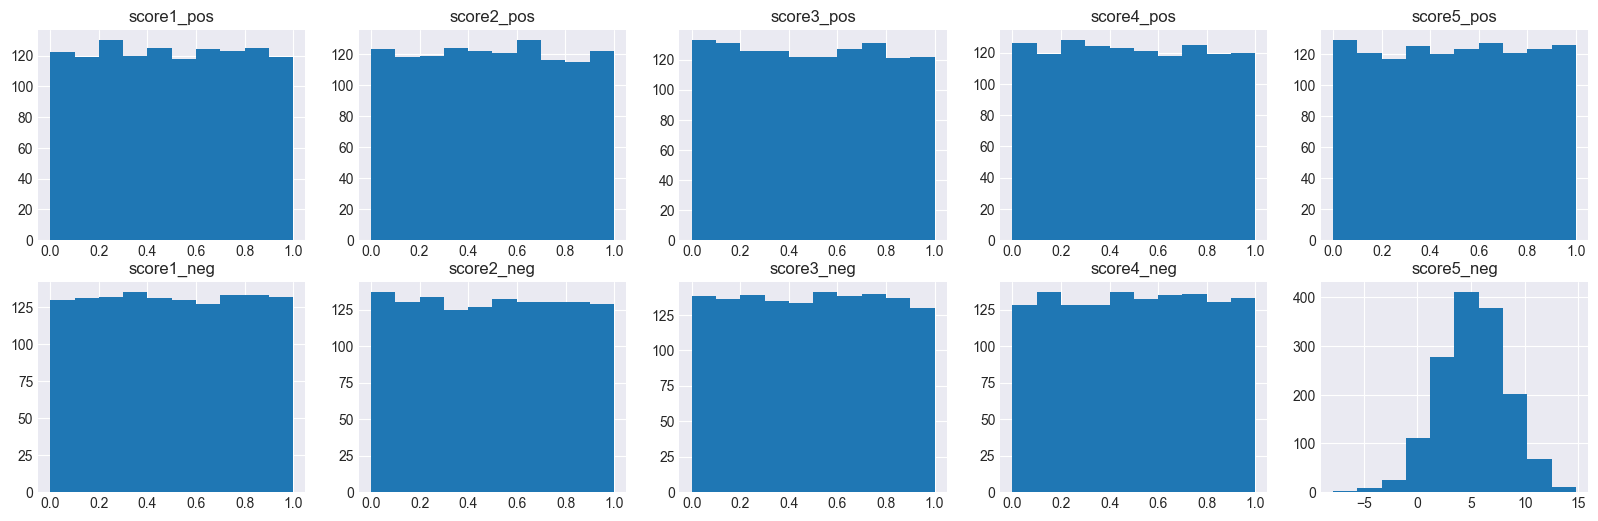

In [309]:
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    train_V2[f"score{k+1}_pos"].hist(ax=axs[0][k])
    train_V2[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

Let's in case of hotel5 convert this score to a quantile value. To do this, we calculate the percentile rank for the score. An alternative would be to get the quantiles from the empirical cumulative distribution function, or rescale the distribution to zero mean and unit variance, assume it's shape to be - let's say - Gaussian and compute the quantiles from that cdf. But let's keep things simple : 

In [310]:
train_V2["score5_neg_uniform"]  = train_V2["score5_neg"].rank(method='max', pct=True)

Text(0.5, 1.0, 'score5_neg_uniform vs score5_pos')

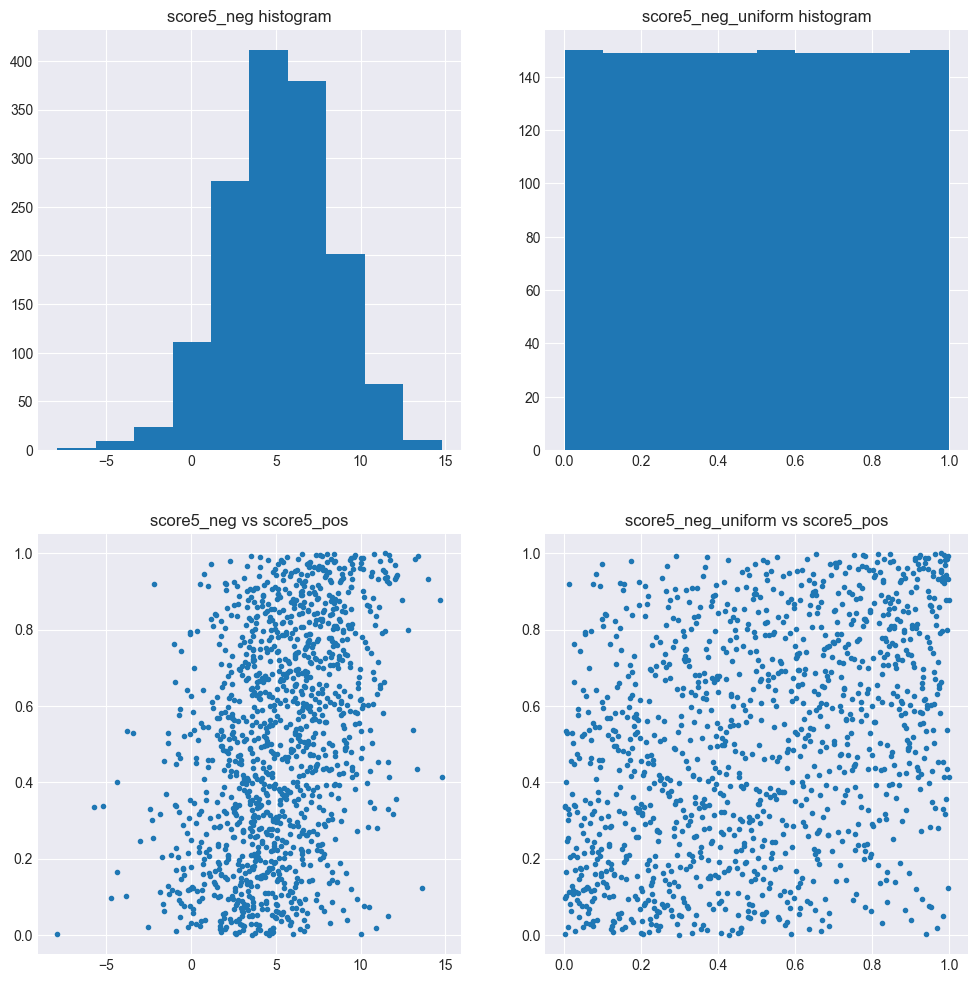

In [311]:
# -- a small check
fig, axs = plt.subplots(2,2, figsize=(12,12))
train_V2["score5_neg"].hist(ax=axs[0][0])
train_V2["score5_neg_uniform"].hist(ax=axs[0][1])

axs[1][0].plot(train_V2["score5_neg"], train_V2["score5_pos"], '.')
axs[1][1].plot(train_V2["score5_neg_uniform"], train_V2["score5_pos"], '.')

axs[0][0].set_title("score5_neg histogram")
axs[0][1].set_title("score5_neg_uniform histogram")
axs[1][0].set_title("score5_neg vs score5_pos")
axs[1][1].set_title("score5_neg_uniform vs score5_pos")

In [312]:
#  -- and now replace the variable in the dataset
train_V2['score5_neg'] = train_V2['score5_neg_uniform']
train_V2.drop(columns=['score5_neg_uniform'], inplace=True)

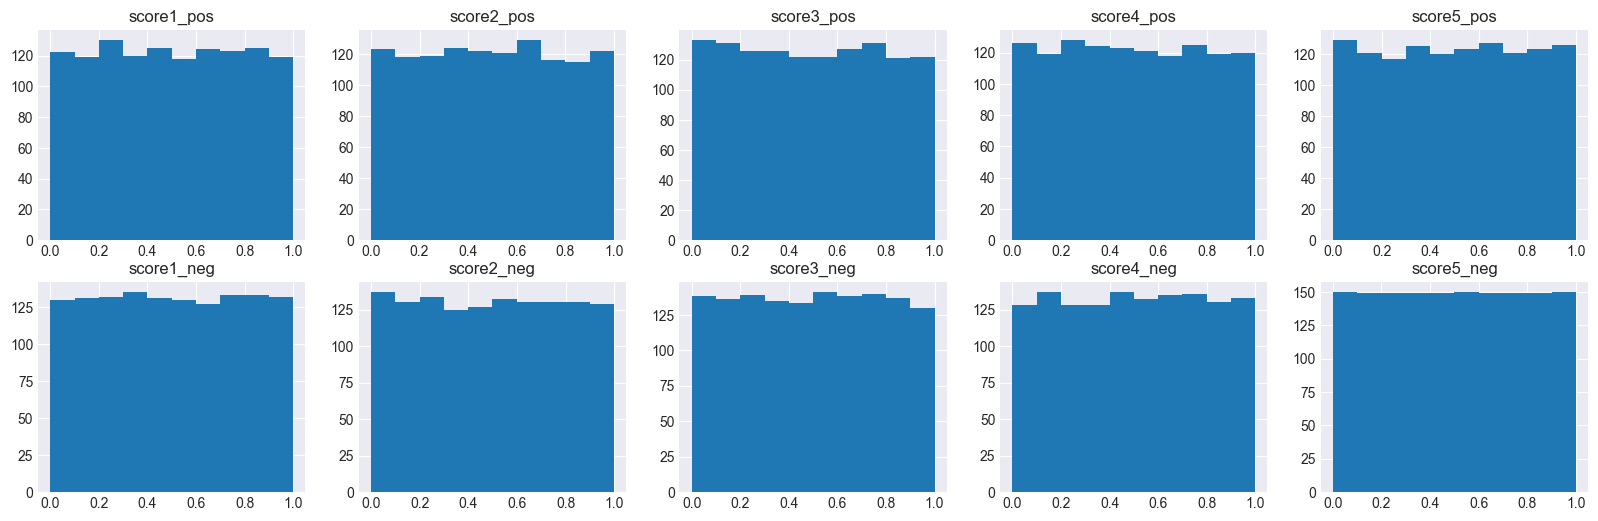

In [313]:
# -- make a small plot to check the resutls:
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    train_V2[f"score{k+1}_pos"].hist(ax=axs[0][k])
    train_V2[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

It still appears a bit strange that the `score5_neg`variable is now so uniform afer converstion to a percentile rank in comparison to the other scores, but let's leave it at that. 

### Assessment of equal features

It seemed strange that there is a variable called `tenure`, once expressed in months, once in years. So lets look a bit closer to the relation between `tenure_mts` and `tenure_yrs` via a scatterplot below : 
From the dictionary one could 


<Axes: xlabel='tenure_mts', ylabel='tenure_yrs'>

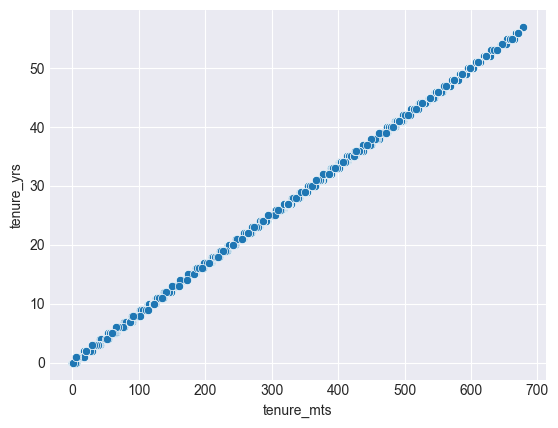

In [314]:
# -- make a scatterplot 
sns.scatterplot(data=train_V2, x='tenure_mts', y='tenure_yrs')


In [315]:
train_V2[(train_V2['divorce']==0) & (train_V2['married_cd']==0)].head()


,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,354.0,30.0,0.0,0.0,0.0,3.0,1.0,1454.210627,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.0
5,5108.0,289.0,6280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,False,6.0,0.0,27621.0,84.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,350.0,29.0,0.0,0.0,0.0,4.0,1.0,0.000000,0.0,1.0,1.0,NaN,NaN,NaN,NaN,0.421064,0.584441,0.872812,0.668272,NaN,NaN,4318.76,0,0.0
14,1480.0,0.0,3819.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,False,0.0,0.0,35505.0,79.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,243.0,20.0,0.0,0.0,0.0,3.0,0.0,0.000000,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.589025,0.235933,0.583424,0.150703,2852.01,0,0.0
20,227.0,0.0,1620.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,False,2.0,0.0,38394.0,83.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,242.0,20.0,0.0,0.0,0.0,4.0,1.0,0.000000,0.0,1.0,0.0,0.661445,0.525109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1324.40,0,0.0
38,556.0,93.0,1721.0,0.0,0.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,False,4.0,0.0,28658.0,75.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,350.0,29.0,0.0,0.0,0.0,34.0,1.0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.777881,0.573342,1319.23,0,0.0


Clearly, both express the same variable, once expressed in years, once in months. This becomes even more explicit when plotting `12*tenure_yrs`versus `tenure_mts` so it probably makes no sense to include both, let's keep `tenure_mts` and drop the `tenure_yrs`

In [316]:
# It appears that for missing tenure_mts, tenure_ys is also missing
# Either tenure_yrs of tenure_mts is missing returns an empty DF
print("shape of dataframe where either tenure_mts of tenure_yrs is missing",train_V2[train_V2.loc[:,['tenure_mts','tenure_yrs']].isnull().sum(axis=1) == 1].shape)


shape of dataframe where either tenure_mts of tenure_yrs is missing (0, 53)


In [317]:
train_V2.drop(columns=['tenure_yrs'], inplace=True)

## Handling of  missing data


### Methodology and TODO's 

1. Getting missing values descending per feature
2. Verwerken van de scores
3. Find instances with missing observations (% of missing for a lot of features is equal > it appears these values for these featues are missing for the same instances)

**TODO**

- [] beter staven waarom we effectief dan nog 53 wegsmijten
- [] de scores uitmiddelen, maar een categorische variabele invoeren die aangeeft van welk hotel afkomstig --> zie: https://github.com/Marijkevandesteene/MachineLearning/issues/8
- [] KNNImputer gebruiken, maar wel features herschalen hiervoor
- [] evt. ook es die IterativeImputer gebruiken (is multivariaat)

### General analysis

In [318]:
# Getting an idea about total missing values
total_missings = train_V2.isnull().sum().sort_values(ascending=False)  # total missng values, sorted
print("Top 20 of most missing features : ")
total_missings.head(40)  # Show top 20 most missing features


Top 20 of most missing features : 


score2_pos          3791
score4_pos          3777
score1_pos          3775
score5_pos          3768
score3_pos          3739
score2_neg          3696
score1_neg          3686
score4_neg          3676
score3_neg          3633
score5_neg          3507
tenure_mts           392
neighbor_income      239
shop_use              88
presidential          88
cab_requests          88
dining_ic             88
company_ic            53
claims_no             53
income_am             53
gold_status           53
nights_booked         53
gender                53
shop_am               53
retired               53
fam_adult_size        53
children_no           53
divorce               53
profit_last_am        53
sport_ic              53
crd_lim_rec           53
credit_use_ic         53
gluten_ic             53
lactose_ic            53
insurance_ic          53
prev_all_in_stay      53
profit_am             53
bar_no                53
age                   53
marketing_permit      53
urban_ic              53


<Axes: title={'center': 'Number of missing values per feature'}>

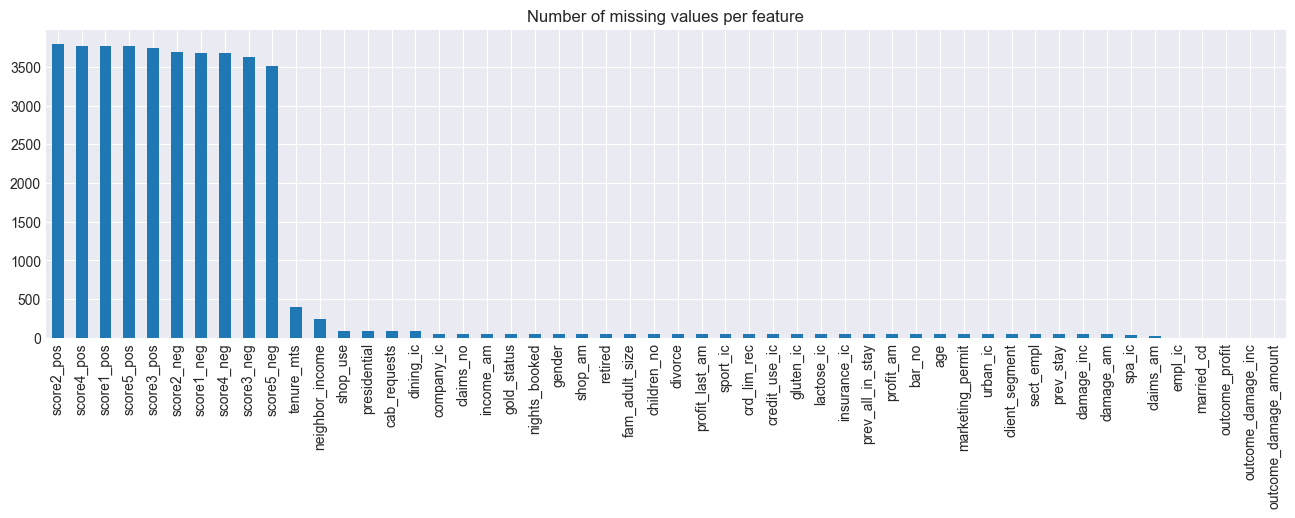

In [319]:
total_missings.plot(kind='bar', figsize=(16,4), title="Number of missing values per feature")

In [320]:
# Getting an idea about percentage missing values
pct_missings = train_V2.isnull().mean().sort_values(ascending=False)  # average (%) missng values, sorted
pct_missings.head(53)  # Show top 20 most missing features

score2_pos               0.7582
score4_pos               0.7554
score1_pos               0.7550
score5_pos               0.7536
score3_pos               0.7478
score2_neg               0.7392
score1_neg               0.7372
score4_neg               0.7352
score3_neg               0.7266
score5_neg               0.7014
tenure_mts               0.0784
neighbor_income          0.0478
shop_use                 0.0176
presidential             0.0176
cab_requests             0.0176
dining_ic                0.0176
company_ic               0.0106
claims_no                0.0106
income_am                0.0106
gold_status              0.0106
nights_booked            0.0106
gender                   0.0106
shop_am                  0.0106
retired                  0.0106
fam_adult_size           0.0106
children_no              0.0106
divorce                  0.0106
profit_last_am           0.0106
sport_ic                 0.0106
crd_lim_rec              0.0106
credit_use_ic            0.0106
gluten_i

<Axes: >

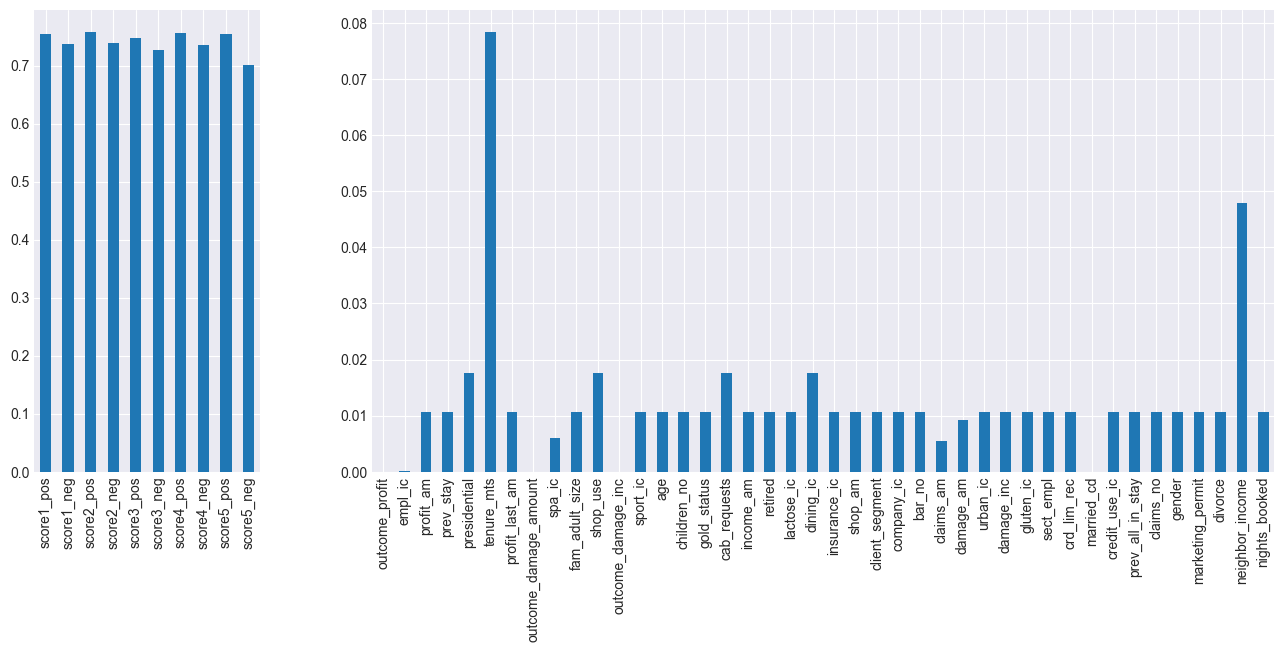

In [321]:
score_vars = [ f"score{i+1}_{xx}" for i in range(5) for xx in ("pos", "neg") ]
other_vars = list(set(train_V2.columns).difference(score_vars))

fig, axs = plt.subplots(1, 2, figsize=(16,6), gridspec_kw={'width_ratios': [1, 4]})

pct_missings[score_vars].plot(kind='bar', ax=axs[0])
pct_missings[other_vars].plot(kind='bar', ax=axs[1])

Some conclusions
- no missing values inthe outcomes
- a lot of missings in the scores
- tenure_mts does have almost 10% missing --> perhaps we should not just drop it, but re-use the years !!

### Imputation of the score values

In [322]:
train_V2["score_pos"] = train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].mean(axis=1)
train_V2["score_neg"] = train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].mean(axis=1)

#### Add category to indicate missing scores

Applying an category to indicate missing scores had a negative impact on performance for the Random Forest 

In [323]:
train_V2['not_null_pos_columns'] = train_V2.apply(lambda row: [col for col in ["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"] if pd.notnull(row[col])], axis=1)
train_V2['not_null_neg_columns'] = train_V2.apply(lambda row: [col for col in ["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"] if pd.notnull(row[col])], axis=1)
train_V2['not_null_pos_columns'] = train_V2['not_null_pos_columns'].apply(tuple)
train_V2['not_null_neg_columns'] = train_V2['not_null_neg_columns'].apply(tuple)

# Create a dictionary to map unique lists to integer identifiers
list_to_id_pos = {str(lst): i for i, lst in enumerate(train_V2['not_null_pos_columns'].unique())}

# Function to assign integer identifier based on the list value
def map_list_to_id(lst):
    return list_to_id_pos[str(lst)]

# Apply the function to create a new column with integer identifiers
train_V2['score_pos_id'] = train_V2['not_null_pos_columns'].apply(map_list_to_id)

# Create a dictionary to map unique lists to integer identifiers
list_to_id_neg = {str(lst): i for i, lst in enumerate(train_V2['not_null_neg_columns'].unique())}

# Function to assign integer identifier based on the list value
def map_list_to_id(lst):
    return list_to_id_neg[str(lst)]

# Apply the function to create a new column with integer identifiers
train_V2['score_neg_id'] = train_V2['not_null_neg_columns'].apply(map_list_to_id)

train_V2.drop(columns=['not_null_neg_columns'], inplace=True)
train_V2.drop(columns=['not_null_pos_columns'], inplace=True)



Text(0.5, 1.0, 'score_pos')

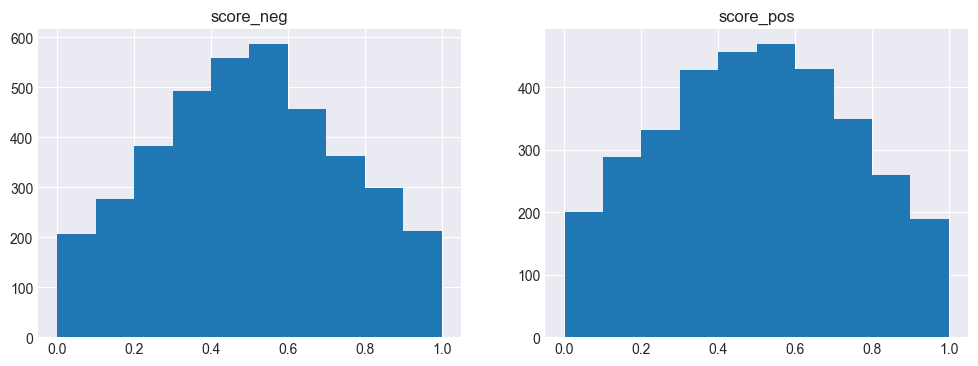

In [324]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
train_V2["score_neg"].hist(ax=axs[0])
train_V2["score_pos"].hist(ax=axs[1])
axs[0].set_title("score_neg")
axs[1].set_title("score_pos")

In [325]:
# Remove the features missing mor than 35% (score*_pos, neg)
print(f"Shape of train_V2 BEFORE dropping missing features: {train_V2.shape}")
missing_a_lot = pct_missings[pct_missings > 0.35].index  # we take from all variables those missing most, and take the row-idx
print(f"Columns missing more than 15% :{missing_a_lot}")
train_V2 = train_V2.drop(missing_a_lot, axis=1)
print(f"Shape of train_V2 AFTER dropping missing features: {train_V2.shape}")

Shape of train_V2 BEFORE dropping missing features: (5000, 56)
Columns missing more than 15% :Index(['score2_pos', 'score4_pos', 'score1_pos', 'score5_pos', 'score3_pos',
       'score2_neg', 'score1_neg', 'score4_neg', 'score3_neg', 'score5_neg'],
      dtype='object')
Shape of train_V2 AFTER dropping missing features: (5000, 46)


to do beter staven ...
Het blijkt dat in de top 20 missing features, er voor een heel aantal variabelen 53 instances missing waren. Vermoedelijk gaat het over dezelfde instances ging.
Na export op basis van 1 van de opgelijste features en bleek dat dit inderdaad voor deze instances het geval was.

Enkel voor deze waarden is er info:
- spa_ic is 21x = 1 (2/21:  outcome_damage_ic = 1)
- empl_ic is 40x = 0 (12/40:  outcome_damage_ic = 1)
- married_cd is 53x = false (12/53::  outcome_damage_ic = 1)
- claims_am is 20x = 0 (6/20:  outcome_damage_ic = 1)

- spa_ic & claims_am & empl_ic is 6x ingevuld

In [327]:
#For a number of instances (53) data seems to be missing for a list of features. These will be eliminated from the dataset
#missing_data.to_csv('missing_data.csv')
instances_missingsData = train_V2[train_V2.loc[:,['company_ic','claims_no','income_am','gold_status','nights_booked','gender','shop_am','retired','fam_adult_size','children_no','divorce','profit_last_am','sport_ic','crd_lim_rec','credit_use_ic','gluten_ic','lactose_ic','insurance_ic','prev_all_in_stay','profit_am','bar_no','age','marketing_permit','urban_ic']].isnull().sum(axis=1) == 24]
print(instances_missingsData.shape)
print(instances_missingsData.index)
train_V2 = train_V2.drop(instances_missingsData.index)

# drop the rows, we already dropped 10 columns, so be careful here... , better way to code this up
#drop_rows = train_V2[train_V2.isnull().sum(axis=1) > 30 ].index

(53, 46)
Index([  90,  306,  474,  517,  670,  790,  996, 1062, 1164, 1261, 1275, 1281,
       1338, 1448, 1696, 1744, 1852, 2058, 2096, 2250, 2348, 2672, 2696, 2734,
       2917, 2956, 3068, 3198, 3213, 3326, 3377, 3494, 3793, 3926, 3952, 3959,
       3990, 4000, 4009, 4138, 4159, 4242, 4392, 4477, 4528, 4545, 4614, 4641,
       4669, 4789, 4851, 4946, 4993],
      dtype='int64', name='Id')


In [328]:
missing_rows = train_V2.isnull().sum().sort_values(ascending=False)
print("These are the features for which we still have missing values : ")
missing_rows[missing_rows>0]

These are the features for which we still have missing values : 


score_pos          1544
score_neg          1113
tenure_mts          339
neighbor_income     186
cab_requests         35
presidential         35
dining_ic            35
shop_use             35
dtype: int64

### Imputation of missing data

#### knn-imputer voor missing scores: add_indicator and rescale

What is the add_indicator parameter in the imputers?
In addition to imputing the missing values, the imputers have an add_indicator parameter that marks the values that were missing, which might carry some information.

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

Pipeline KNNImputer / IterativeImputer
https://stackoverflow.com/questions/64900801/implementing-knn-imputation-on-categorical-variables-in-an-sklearn-pipeline#:~:text=My%20pipeline%20includes%20sklearn%27s%20KNNImputer%20estimator,impute%20categorical%20features%20in%20my%20dataset.&text=My%20pipeline%20includes%20sklearn%27s,features%20in%20my%20dataset.&text=includes%20sklearn%27s%20KNNImputer%20estimator,impute%20categorical%20features%20in

In [329]:
from sklearn.impute import SimpleImputer, KNNImputer

In [330]:
missing_feats = missing_rows[missing_rows>0].index.to_list()
print("Feature with missing values : ")
print(missing_feats)

Feature with missing values : 
['score_pos', 'score_neg', 'tenure_mts', 'neighbor_income', 'cab_requests', 'presidential', 'dining_ic', 'shop_use']


In [331]:
missing_feats_categorical = ['presidential', 'dining_ic', 'shop_use']
missing_feats_continuous = ['tenure_mts', 'neighbor_income', 'cab_requests','score_pos','score_neg']

In [332]:
# get all the missing features, with SimpleImputer we have to select between continuous & categorical features
# probably here as well, for now we're just using the uniform weights, but check afterwards if the categorical
# values are ok
imputer_knn = KNNImputer(n_neighbors=5, weights='uniform', add_indicator=False).set_output(transform="pandas")

train_V2 = imputer_knn.fit_transform(X=train_V2)

In [333]:
# Total amount of missings
total_total_missings = train_V2.isnull().sum().sum()
print(f'Are there any missings at all anymore, if this is zero, there are none: {total_total_missings}')
# YAY!

Are there any missings at all anymore, if this is zero, there are none: 0


## Anomaly and outlier detection


Hoeven niet noodzakelijk dingen eruit te zwieren, maar wel minstens aangeven dat we er naar gekeken hebben en argumenteren waarom er niets uit gaat. 

11% wordt aangeduid als een anomaly. 
Dat lijkt het vermoeden dat er niet echt outliers zijn te bevestigen.

In [334]:
# Can not handle missing values
# Fitting default isolation forest for anomaly/outlier detection
# Importing the correct class as usual
from sklearn.ensemble import IsolationForest

# Checking which hyperparameters are available
# print(f"Hyperparamerters for IsolationForest class: {IsolationForest().get_params()}")

# Initializing model
if_model = IsolationForest(n_estimators=100, random_state=seed)

# Fitting (only X data, because unsupervised)
X_train_V2 = train_V2.drop(columns=['outcome_profit','outcome_damage_inc','outcome_damage_amount'], inplace=False)
if_model.fit(X=X_train_V2)

# Predicting on the same data
y_pred_train = if_model.predict(X=X_train_V2)

# Checking frequency table of predicted values
print('Frequency table of predicted values:')
pd.Series(y_pred_train).value_counts(normalize=True)

Frequency table of predicted values:


 1    0.880736
-1    0.119264
Name: proportion, dtype: float64

# Visualisations and exploratory analysis

Now that we have reasonably clean data, let's perform some initial exploratory analysis, correlation plots, etc...

In [335]:
# The outcome to maximize is profit - damage

# don't assign to dataframe just yet ???
train_V2['revenue'] = train_V2['outcome_profit'] - train_V2['outcome_damage_amount']

In [ ]:
# Checking univariate distribution of the revenue
sns.displot(train_V2['revenue']);  # With seaborn for a change
plt.xticks(rotation=45); # Rotating x labels

In [ ]:
# But I guess a scatter plot would've done well also

plt.scatter(x = range(0, 0 + len(train_V2)),y=train_V2['revenue'], alpha=0.5);  # alpha=0.5 makes it a bit see through
plt.xlabel('Id');
plt.ylabel('revenue');
plt.title('Alternative: scatter plot');
plt.show() 

In [ ]:
# Plotting
x = 'neighbor_income'
plt.figure(figsize=(8, 6))
plt.scatter(x=train_V2[x], y=train_V2['outcome_profit']);
plt.scatter(x=train_V2[x], y=train_V2['outcome_damage_amount']);
plt.title('profit and damage');
plt.xlabel(x);

In [ ]:
# Boxplot-type for year built vs SalePrice
plt.figure(figsize=(25, 10), dpi=500)  # Bumping up image size and DPI for better viewing
sns.boxplot(x='divorce', y='outcome_profit', data=train_V2);
plt.xticks(rotation=90);  # To rotate x-axis labels
plt.title('Relationship of divorce versus profit');
plt.show()  # remember: necessary to do this when trying to plot multiple plots from a single cell!

# But I guess a scatter plot would've done well also
plt.scatter(x=train_V2['income_am'], y=train_V2['outcome_profit'], alpha=0.5);  # alpha=0.5 makes it a bit see through
plt.xlabel('income_am');
plt.ylabel('outcome_profit');
plt.title('Alternative: scatter plot of income versus profit');
plt.show() 

# Correlation matrix between features
#corrmat = train_V2.corr(numeric_only=True)  # Since Pandas 2.0 you need to supply this attribute
corrmat = train_V2.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit'], axis=1).corr(numeric_only=True) 
plt.figure(figsize=(12, 12));
sns.heatmap(corrmat, vmax=1, square=True);
# Note, we keep SalePrice in here as well, proceed with caution (no data snooping!)

# Scatterplot matrix (might take a while)
plot_cols = ['outcome_damage_inc', 'income_am', 'profit_last_am', 'profit_am', 'damage_am', 'damage_inc', 'crd_lim_rec']
sns.pairplot(train_V2[plot_cols], height=2.5);

# Standardizing : NOT NEEDED FOR RF


In [ ]:
# Standardizing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform='pandas')
train_v2_stan_df = scaler.fit_transform(X=train_V2)

# Model training


Goal of the exam : What do we need to predict? Is it available as outcome in our data?
1. the revenue per client (= profit - damage)
    - needs to be calculated
2. predict which clients will cause damage
    - outcome_damage_inc
3. predict the amount of damage fot those who will cause damage / wreak havoc
    - outcome_damage_amount

Calculate revenue


## TODO

- es trainen op apart amount profit & damage, maar ook es op verschil (revenue)

## verdeling

- Bino : GBM
- Marijke : RF
- Dries : SVR/SVC
- Logistic regression for question 2 + Model performance evaluation: lift curve / Calibration Curve

## Random forest
### Model to predict revenue per client

Goal of the What do we need to predict? Is it available as outcome in our data
1. the revenue per client (= profit - damage)
    - needs to be calculated


In [336]:
# Making train-test set split (Note: we're taking 30% test set size here instead of 20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit'], axis=1), # features DF
                                                    train_V2['revenue'],   # target DF/series
                                                    test_size=0.3, # 30% as test or validation set (who cares about the exact names)
                                                    shuffle=True,  # This shuffles the data! (Important)
                                                    random_state=seed)  # setting seed for consistent results

In [337]:
# Random Forest for classification - random search 3-fold CV - this can take a while
from sklearn.ensemble import RandomForestRegressor

# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=20)]  # list comprehension because we want integers!
max_features = [int(x) for x in np.linspace(start=5, stop=150, num=20)] 
max_depth = [int(x) for x in np.linspace(start=2, stop=50, num=10)]
max_depth.append(None)  # adding 'None' option as well
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 10]
bootstrap = [True, False]
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

# Define data splitter to be used in the search
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define amount of hyperparameter tuning combinations to sample
n_hyperparams_sample = 100

# Defining model to apply random search CV hyperparam tuning on
rf = RandomForestRegressor()

# Initializing random search CV object
rf_hyperparam_tuning_random = RandomizedSearchCV(estimator=rf, 
                                          param_distributions=hyperparam_grid, 
                                          n_iter=n_hyperparams_sample, 
                                          cv=kfold,
                                          verbose=2, 
                                          random_state=seed, 
                                          n_jobs=-1)

# Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
rf_hyperparam_tuning_random.fit(X=X_train, y=y_train)

print('Optimally found RF hyperparams after this random search: \n{}' .format(rf_hyperparam_tuning_random.best_params_))

# Refitting the optimal model on the whole training dataset
rf_random_best = rf_hyperparam_tuning_random.best_estimator_
rf_random_best.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rf_random_best_y_train_pred = rf_random_best.predict(X=X_train)
rf_random_best_y_test_pred = rf_random_best.predict(X=X_test)

# Checking accuracy manually
print('Train R2: %.3f' % rf_random_best.score(X=X_train, y=y_train))
print('Test R2: %.3f' % rf_random_best.score(X=X_test, y=y_test))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Optimally found RF hyperparams after this random search: 
{'n_estimators': 121, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 58, 'max_depth': 18, 'bootstrap': True}
Train R2: 0.990
Test R2: 0.956


In [ ]:
pickle.dump(rf_random_best, open('RF_model_revenue.pkl','wb'))

In [ ]:
# Extracting hyperparameter tuning results and checking
rf_cv_res = pd.DataFrame(rf_hyperparam_tuning_random.cv_results_)

# Scatter plot of selection of hyperparams vs performance
plot_hyperparams = ['param_max_depth', 'param_min_samples_leaf', 'param_n_estimators']  
# in the .cv_results_ there is always a 'param_' prefix!

for param in plot_hyperparams:
    plt.figure(); # This command will help in the plots not 'falling' on top of each other ;)
    plt.scatter(x=rf_cv_res[param], y=rf_cv_res['mean_test_score'], alpha=0.7); # alpha to get some opacity
    plt.xlabel(param);
    plt.ylabel('CV R2')
    plt.title(f"Hyperparameter: {param} vs. CV R2")

This picture brings some nuance to the 'best' random forests: let's start with `max_depth`: apparently, you can find similarly good trees at lower depth; but the very lowest depths perform rather bad. This may give us a bit of benefit in terms of generalization error. 

For the minimal samples per leaf (`min_samples_leaf`), the picture really prefers not to shy away from small leafs: it seems that going into unique values is worth it. Finally, let's see whether we need a lot of trees or not.

With regards to the amount of trees `n_estimators`: you don't seem to necessarily need many trees in your forest to get a good model. This is good to know for future training, but realize that with more complex forests, you may need more trees to improve generalization error. So let's not restrict the forests too much in the grid search. 

Now, do realize that these kinds of analyses are to be taken with a grain of salt in the section on GBMs we go 1 small step beyond and make plot that take 2 hyperparameters at once in consideration, which might already help a bit more. But for now, we'll keep it simple.

Another word of caution: sometimes, due to randomness, the best was at the boundary of the search space, let's increase the options a bit more in the grid search. Since we don't care too much about the size of the object, we're probably better of grid searching higher values, but with less options (this keeps the training time low).

### Model to predict which clients will cause damage

Goal of the What do we need to predict? Is it available as outcome in our data

2. predict which clients will cause damage
    - outcome_damage_inc

Train-test set split for output = output_damage_inc

In [ ]:
# Making train-test set split (Note: we're taking 30% test set size here instead of 20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','revenue','outcome_profit'], axis=1), # features DF
                                                    train_V2['outcome_damage_inc'],   # target DF/series
                                                    test_size=0.2, # 30% as test or validation set (who cares about the exact names)
                                                    shuffle=True,  # This shuffles the data! (Important)
                                                    random_state=seed)  # setting seed for consistent results


In [ ]:
# NOT NEEDED for RF
# I'll also make standardized (normalized) versions
scaler = StandardScaler().set_output(transform='pandas')
scaler.fit(X=X_train)
X_train_norm = scaler.transform(X=X_train)
X_test_norm = scaler.transform(X=X_test)

In [ ]:
X_train.head()

In [ ]:
# Random Forest for classification - random search 3-fold CV - this can take a while
from sklearn.ensemble import RandomForestClassifier

# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=5)]  # list comprehension because we want integers!
max_features = [int(x) for x in np.linspace(start=5, stop=150, num=20)] 
max_depth = [int(x) for x in np.linspace(start=2, stop=40, num=10)]
max_depth.append(None)  # adding 'None' option as well
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 10]
bootstrap = [True, False]
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

# Define data splitter to be used in the search
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define amount of hyperparameter tuning combinations to sample
n_hyperparams_sample = 100

# Defining model to apply random search CV hyperparam tuning on
rf = RandomForestClassifier()

# Initializing random search CV object
rf_hyperparam_tuning = RandomizedSearchCV(estimator=rf, 
                                          param_distributions=hyperparam_grid, 
                                          n_iter=n_hyperparams_sample, 
                                          cv=kfold,
                                          verbose=2, 
                                          random_state=seed, 
                                          n_jobs=-1)

# Executing / fitting the random search 
rf_hyperparam_tuning.fit(X=X_train, y=y_train)
print('Optimal hyperparameter values according to our random search: \n{}' .format(rf_hyperparam_tuning.best_params_))

# Refitting the optimal model on the whole training dataset
rf_opt1 = rf_hyperparam_tuning.best_estimator_
rf_opt1.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rf_opt1_y_train_pred = rf_opt1.predict(X=X_train)
rf_opt1_y_test_pred = rf_opt1.predict(X=X_test)

# Checking accuracy manually
print('Train accuracy of the refitted model: %.3f' % rf_opt1.score(X=X_train, y=y_train))
print('Test accuracy of the refitted model: %.3f' % rf_opt1.score(X=X_test, y=y_test))

# Classification report 
target_names = ['no damage', 'damage']
print(classification_report(y_true=y_test, y_pred=rf_opt1_y_test_pred, target_names=target_names))

In [ ]:
pickle.dump(rf_opt1, open('RF_model_damage_inc.pkl','wb'))

In [ ]:
# Extracting hyperparameter tuning results and checking
rf_cv_res = pd.DataFrame(rf_hyperparam_tuning.cv_results_)

# Scatter plot of selection of hyperparams vs performance
plot_hyperparams = ['param_max_depth', 'param_min_samples_leaf', 'param_n_estimators']  
# in the .cv_results_ there is always a 'param_' prefix!

for param in plot_hyperparams:
    plt.figure(); # This command will help in the plots not 'falling' on top of each other ;)
    plt.scatter(x=rf_cv_res[param], y=rf_cv_res['mean_test_score'], alpha=0.7); # alpha to get some opacity
    plt.xlabel(param);
    plt.ylabel('CV R2')
    plt.title(f"Hyperparameter: {param} vs. CV Accuracy")

### Model to predict the amount of damage per client

Goal of the What do we need to predict? Is it available as outcome in our data

3. predict the amount of damage fot those who will cause damage / wreak havoc
    - outcome_damage_amount

#### Train-stest set split


In [ ]:
# Making train-test set split (Note: we're taking 30% test set size here instead of 20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['revenue','outcome_damage_inc','outcome_profit'], axis=1), # features DF
                                                    train_V2['outcome_damage_amount'],   # target DF/series
                                                    test_size=0.3, # 30% as test or validation set (who cares about the exact names)
                                                    shuffle=True,  # This shuffles the data! (Important)
                                                    random_state=seed)  # setting seed for consistent results

In [ ]:
X_train.head()

In [ ]:
# Random Forest for classification - random search 3-fold CV - this can take a while
from sklearn.ensemble import RandomForestRegressor

# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=20)]  # list comprehension because we want integers!
max_features = [int(x) for x in np.linspace(start=5, stop=150, num=20)] 
max_depth = [int(x) for x in np.linspace(start=2, stop=50, num=10)]
max_depth.append(None)  # adding 'None' option as well
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 10]
bootstrap = [True, False]
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

# Define data splitter to be used in the search
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define amount of hyperparameter tuning combinations to sample
n_hyperparams_sample = 100

# Defining model to apply random search CV hyperparam tuning on
rf = RandomForestRegressor()

# Initializing random search CV object
rf_hyperparam_tuning_random = RandomizedSearchCV(estimator=rf, 
                                          param_distributions=hyperparam_grid, 
                                          n_iter=n_hyperparams_sample, 
                                          cv=kfold,
                                          verbose=2, 
                                          random_state=seed, 
                                          n_jobs=-1)

# Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
rf_hyperparam_tuning_random.fit(X=X_train, y=y_train)

print('Optimally found RF hyperparams after this random search: \n{}' .format(rf_hyperparam_tuning_random.best_params_))

# Refitting the optimal model on the whole training dataset
rf_random_best = rf_hyperparam_tuning_random.best_estimator_
rf_random_best.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rf_random_best_y_train_pred = rf_random_best.predict(X=X_train)
rf_random_best_y_test_pred = rf_random_best.predict(X=X_test)

# Checking accuracy manually
print('Train R2: %.3f' % rf_random_best.score(X=X_train, y=y_train))
print('Test R2: %.3f' % rf_random_best.score(X=X_test, y=y_test))



In [ ]:
pickle.dump(rf_random_best, open('RF_model_damage_amount.pkl','wb'))

In [ ]:
# Extracting hyperparameter tuning results and checking
rf_cv_res = pd.DataFrame(rf_hyperparam_tuning_random.cv_results_)

# Scatter plot of selection of hyperparams vs performance
plot_hyperparams = ['param_max_depth', 'param_min_samples_leaf', 'param_n_estimators']  
# in the .cv_results_ there is always a 'param_' prefix!

for param in plot_hyperparams:
    plt.figure(); # This command will help in the plots not 'falling' on top of each other ;)
    plt.scatter(x=rf_cv_res[param], y=rf_cv_res['mean_test_score'], alpha=0.7); # alpha to get some opacity
    plt.xlabel(param);
    plt.ylabel('CV R2')
    plt.title(f"Hyperparameter: {param} vs. CV R2")

### To Do Predict probability / Calibration


# To Do: list of 200 / selection of hotel guest with the highest revenue
# For EXECUTIVE SUMMARY : Compare the list of selected hotel guests across different algorithm and select the top 200 identified by all three approaches???

1. Gradient Booster
2. Random Forest
3. SVM